In [1]:
import torch
import random
import os
import numpy as np
import pickle5 as pickle
from pathlib import Path
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.utils.data import DataLoader
import albumentations as A
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from utils.dataloaders import Birds_OneCluster, ACDCDataset, ShapeDataset, Birds_Dataset
from utils.common import get_model

### Birds inference

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import pickle5 as pickle
with open("/home/e_radionova/DeepCluster/deepcluster/checkpts_Birds_1500epochs_30cls/clusters", "rb") as f:
    clusters = pickle.load(f)
epoch = 1000
num_cluster = 3
cluster_idxs = clusters[epoch][num_cluster]

In [3]:
def find_names_in_fold(prefix):
    images_names = np.sort(os.listdir(prefix))
    list_names = np.sort(os.listdir(prefix / images_names[0])).tolist()
    for i, x in enumerate(list_names):
        list_names[i] = os.path.join(images_names[0],x)
    for i in images_names[1:]:
        list_names_onefold = np.sort(os.listdir(prefix / i)).tolist()
        for j, x in enumerate(list_names_onefold):
            list_names_onefold[j] = os.path.join(i, x)
        list_names.extend(list_names_onefold)
    return list_names

In [4]:
dataset_path = Path('/home/e_radionova/Datasets/Caltech_birds/CUB_200_2011/dataset')
train_imgs_path = dataset_path /  'train/images/'
train_masks_path = dataset_path /  'train/masks/'

In [5]:
train_masks_names = find_names_in_fold(train_masks_path)
train_imgs_names = find_names_in_fold(train_imgs_path)

In [6]:
lst_cluster_masks = [train_masks_names[i] for i in cluster_idxs]
lst_cluster_imgs = [train_imgs_names[i] for i in cluster_idxs]

In [7]:
from sklearn.model_selection import train_test_split
train_imgs, test_imgs, train_masks, test_masks = train_test_split(lst_cluster_imgs, lst_cluster_masks, 
                                                                  test_size=0.3, random_state=42)

In [8]:
trans = transforms.Compose([
    transforms.CenterCrop((400, 400)),
    transforms.ToTensor(),
])

train_set = Birds_OneCluster(img_names = train_imgs, 
                             mask_names = train_masks, 
                             images_folder = dataset_path / 'train/images', 
                             masks_folder = dataset_path / 'train/masks',
                             clusters=None,
                             cluster_num=3,
                             cluster_epoch=1000, 
                             img_transform = trans, 
                             masks_transform = trans)

val_set = Birds_OneCluster(img_names = test_imgs, 
                           mask_names = test_masks,
                           images_folder = dataset_path / 'train/images',
                           masks_folder = dataset_path / 'train/masks',
                           clusters=None,
                           cluster_num=3,
                           cluster_epoch=1000, 
                           img_transform = trans,
                           masks_transform = trans)

In [1]:
image_datasets = {
    'train': train_set , 'val': val_set
}

batch_size_train = 32

batch_size_val = batch_size_train

dataloaders_birds = {
    'train': DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size_val, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

In [1]:
inputs = torch.Tensor()
masks = torch.Tensor()
seeds = [8, 3, 5, 6, 8]
idxs = [5,2,3,3,2]
for i in range(len(seeds)):
    random.seed(seeds[i])
    torch.manual_seed(seeds[i])
    torch.cuda.manual_seed_all(seeds[i])
    np.random.seed(seeds[i])
    inputs_1, masks_1 = next(iter(dataloaders_birds['val']))
    inputs_1 = inputs_1[3:9]
    masks_1 = masks_1[3:9]
    inputs_1 = inputs_1[[idxs[i]]]
    masks_1 = masks_1[[idxs[i]]]
    inputs = torch.cat((inputs, inputs_1), dim=0)
    masks = torch.cat((masks, masks_1), dim=0)

half = 2
fig, ax = plt.subplots(2, half, figsize=(10, 10))
plt.subplots_adjust(wspace=0.1,hspace=0.001)
for i in range(4):
    pic, label = inputs[i], masks[i]
    label_np = label.data.numpy().transpose(1, 2, 0)
    pic_np = pic.data.numpy().transpose(1, 2, 0)
    ax[i//half, i%half].imshow(label_np, cmap='gray')
    ax[i//half, i%half].axis('off')

In [ ]:
SEED_ = 8
random.seed(SEED_)
torch.manual_seed(SEED_)
torch.cuda.manual_seed_all(SEED_)
np.random.seed(SEED_)

n_pics_to_show = 4
inputs_birds, masks_birds = next(iter(dataloaders_birds['val']))
inputs = inputs_birds[[3,4,5,7,8]]
masks = masks_birds[[3,4,5,7,8]]
fig, ax = plt.subplots(n_pics_to_show, 2, figsize=(7, 12))
for i in range(4):
    pic, label = inputs[i], masks[i]
    label_np = label.data.numpy().transpose(1, 2, 0) 
    pic_np = pic.data.numpy().transpose(1, 2, 0) 
    ax[i,0].imshow(pic_np, cmap='gray')
    ax[i,1].imshow(label_np, cmap='gray')

#### model

In [15]:
def get_model_out(inputs, model):
    with torch.no_grad():
        output = model(inputs.float().cuda())
        output = F.sigmoid(output)
        output = output.cpu().detach().numpy()
    return output

In [16]:
model_names = ['unet', 'attention-unet', 'lorck', 'def-convs', 'unet_init', 'hybrid']
k_sizes = [3, 3, 3, 3, 7, 7]

In [17]:
acdc_logs = Path('/home/e_radionova/PROJECT/optimal-kernels/IJCAI/weights/birds')
acdc_weights_dct={
        'unet': 'unet_birds_b4_with_k_size_15_2022-01-16T17:36.pth',
        'attention-unet': 'attention-unet_birds_b4_with_k_size_15_2022-01-16T17:24.pth',
        'lorck': 'lorck_birds_b4_with_k_size_15_2022-01-16T17:58.pth',
        'def-convs': 'def-convs_birds_b4_with_k_size_15_2022-01-16T17:53.pth',
        'unet_init': 'unet_init_birds_b4_with_k_size_7_2022-03-15T00:13.pth',
        'hybrid': 'hybrid_birds_b4_with_k_size_7_2022-03-18T23:06.pth'
}


In [18]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

dct_models = {}
dct_outputs = {}
for i in range(len(model_names)):    
    model = get_model(model_names[i], in_chs=3, out_chs=1, k_size=k_sizes[i])
    model = model.to(device)
    weight = acdc_logs / acdc_weights_dct[model_names[i]]
    model.load_state_dict(torch.load(weight))
    model.eval()
    
    outputs = get_model_out(inputs, model)
    
    dct_models[model_names[i]] = model
    dct_outputs[model_names[i]] = outputs

/home/e_radionova/anaconda3/envs/py37_torchh_last/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/e_radionova/anaconda3/envs/py37_torchh_last/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [20]:
from utils.loss import dice_loss

In [26]:
j=0
for name in model_names:
    dice1 = 1 - dice_loss(torch.from_numpy(dct_outputs[name][j][[0]]).unsqueeze(0), 
                         masks[j][[0]].unsqueeze(0))

    print(name)
    print('DICE:', round(float(dice1),4))

unet
DICE: 0.705
attention-unet
DICE: 0.8516
lorck
DICE: 0.9079
def-convs
DICE: 0.5974
unet_init
DICE: 0.8522
hybrid
DICE: 0.9016


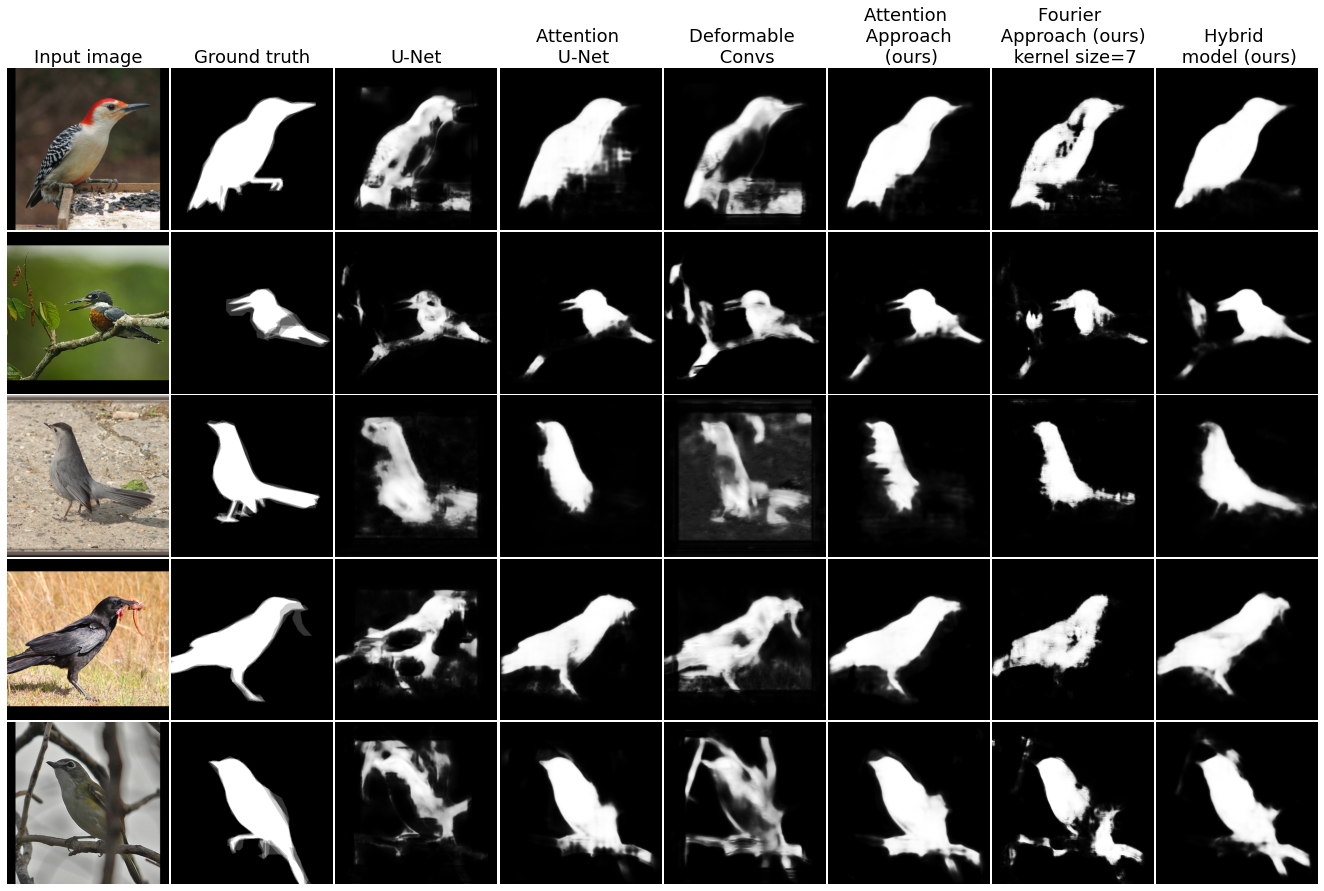

In [25]:
fig, ax = plt.subplots(5, 8, figsize=(23.5, 15))
plt.subplots_adjust(wspace=0.01,hspace=0.01)
alpha = 1
for i in range(5):
    ax[i, 0].imshow(inputs[i].permute(1,2,0), cmap='gray')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(masks[i].permute(1,2,0), cmap='gray', alpha=alpha)    
    ax[i, 1].axis('off')
    
    ax[i, 2].imshow(dct_outputs['unet'][i].transpose(1,2,0), cmap='gray', alpha=alpha)
    ax[i, 2].axis('off')
    
    ax[i, 3].imshow(dct_outputs['attention-unet'][i].transpose(1,2,0), cmap='gray', alpha=alpha)
    ax[i, 3].axis('off')
    
    ax[i, 4].imshow(dct_outputs['def-convs'][i].transpose(1,2,0), cmap='gray', alpha=alpha)
    ax[i, 4].axis('off')
    
    ax[i, 5].imshow(dct_outputs['lorck'][i].transpose(1,2,0), cmap='gray', alpha=alpha)
    ax[i, 5].axis('off')
    
    ax[i, 6].imshow(dct_outputs['unet_init'][i].transpose(1,2,0), cmap='gray', alpha=alpha)
    ax[i, 6].axis('off')
    
    ax[i, 7].imshow(dct_outputs['hybrid'][i].transpose(1,2,0), cmap='gray', alpha=alpha)
    ax[i, 7].axis('off')
    
    name_size=18
    ax[0, 0].set_title('Input image', fontsize=name_size)
    ax[0, 1].set_title('Ground truth', fontsize=name_size)
    ax[0, 2].set_title('U-Net', fontsize=name_size)
    ax[0, 3].set_title('Attention \n U-Net', fontsize=name_size)    
    ax[0, 4].set_title('Deformable \n Convs', fontsize=name_size)
    ax[0, 5].set_title('Attention \n Approach \n (ours)', fontsize=name_size)
    ax[0, 6].set_title('Fourier \n Approach (ours) \n kernel size=7', fontsize=name_size)
    ax[0, 7].set_title('Hybrid \n model (ours)', fontsize=name_size)
plt.show()

In [93]:
fig.savefig('./imgs/birds.png', dpi=100)
plt.close(fig)